In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [712]:
from evrp.utils.utilities import *
from evrp.utils.graph import draw_plain_graph, draw_graph
from evrp.utils.plot import plot_interactive_graph
from evrp.milp.tsp import TSP
from evrp.milp.vrptw import VRPTW
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np
from scipy.spatial import distance

import pprint

import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.colors as pltc

import itertools

import networkx as nx

from pyomo.environ import *

from evrp.config.GLOBAL_CONFIG import *

pd.options.plotting.backend = "plotly"
pp = pprint.PrettyPrinter()

In [546]:
instance = 'r105c5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [1036]:
m = EVRPTW()
m.solve(fpath)

2021-01-15 03:31:50 INFO     Building abstract model
2021-01-15 03:31:50 INFO     Defining parameters and sets
2021-01-15 03:31:50 INFO     Defining variables
2021-01-15 03:31:50 INFO     Defining constraints
2021-01-15 03:31:50 INFO     Defining objective
2021-01-15 03:31:50 INFO     Importing EVRPTW MILP instance: r105c5_e
2021-01-15 03:31:50 INFO     Reading CSV
2021-01-15 03:31:50 INFO     Creating graph
2021-01-15 03:31:50 INFO     Creating timeseries data
2021-01-15 03:31:50 INFO     Creating duplicates and extended graph
2021-01-15 03:31:50 INFO     Calculating distance matrix
2021-01-15 03:31:50 INFO     Creating parameters
2021-01-15 03:31:50 INFO     Creating instance
2021-01-15 03:31:51 INFO     Solving instance...



--------------------------------------------
--------------------------------------------

Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-28
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpra3p0vwn.pyomo.lp
Reading time = 0.03 seconds
x2933: 272 rows, 2933 columns, 992 nonzeros
No parameters matching 'MaxTime' found
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 272 rows, 2933 columns and 992 nonzeros
Model fingerprint: 0xcff8a7dc
Model has 1380 quadratic objective terms
Model has 5652 quadratic constraints
Variable types: 1420 continuous, 1513 integer (1513 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 3e+02]
  Objective range  [4e+00, 5e+02]
  QObjective range [2e-01, 6e-01]
  Bounds range     [1e+00,

2021-01-15 03:32:07 INFO     Done


In [1037]:
print(m.results)


Problem: 
- Name: x2933
  Lower bound: 1166.4965823362163
  Upper bound: 1166.4965823362163
  Number of objectives: 1
  Number of constraints: 5924
  Number of variables: 2933
  Number of binary variables: 1513
  Number of integer variables: 1513
  Number of continuous variables: 1420
  Number of nonzeros: 992
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 15.25275993347168
  Error rc: 0
  Time: 15.430068016052246
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [1038]:
var_list = ['xkappa', 'xp']
x = merge_variable_results(m, var_list)

In [1039]:
xp = x[x['state']>1e-4].sort_values(['t'], ascending=True)
# print(xp.to_string())
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,12227,101.0,62.389004
S0_1,6467,34.0,52.025101
S13_0,4759,32.0,0.000000
S13_1,977,18.0,36.734694
S1_0,6945,82.0,0.000000
S1_1,70,1.0,0.000000


In [1040]:
var_list = ['xgamma', 'xw', 'xq', 'xa']
x = merge_variable_results(m, var_list)

In [1041]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa
23,D0,S0_1,1.0,0.000000,0.0,29.305445
12,D0,S0_0,1.0,25.935551,0.0,29.305445
102,S0_1,C75,1.0,62.071502,200.0,53.545658
86,C75,C91,1.0,107.000000,182.0,18.617159
73,C91,S13_1,1.0,123.708204,0.0,11.908955
128,S13_1,C95,1.0,146.180340,39.0,44.171513
112,S0_0,C78,1.0,158.000000,19.0,60.630000
98,C78,C28,1.0,213.000000,16.0,35.630000
8,C28,D1,1.0,230.000000,0.0,29.305445
11,C95,D1,1.0,230.000000,0.0,29.305445


In [1042]:
test = x[x['state']>1e-4].sort_values(['xw'])
route = zip(test['from'], test['to'])
sum([m.data['d'].loc[fr, to] for fr, to in route])

151.14879946121792

In [1043]:
e, e_flat = create_optimal_edges(m, x=x, graph='V_')

In [1044]:
plot_interactive_graph(m.data['V'], e=e_flat, obj=m.instance.obj(), instance_name=m.instance_name)

In [1045]:
m.instance.constraint_energy_start_end_soe.pprint()

constraint_energy_start_end_soe : Size=1, Index=constraint_energy_start_end_soe_index, Active=True
    Key          : Lower : Body            : Upper : Active
    ('D0', 'D1') :   0.0 : xa[D0] - xa[D1] :   0.0 :   True


In [1046]:
m.instance.xa['D0'].pprint()

{Member of xa} : Size=13, Index=V01_
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
     D0 :     0 : 29.30544467966324 :  None : False : False : NonNegativeReals


In [1047]:
m.data['d']

,D0,D1,S0_0,S0_1,S1_0,S1_1,S13_0,S13_1,C91,C28,C75,C78,C95
D0,0.000000,0.000000,0.000000,0.000000,29.068884,29.068884,19.104973,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
D1,0.000000,0.000000,0.000000,0.000000,29.068884,29.068884,19.104973,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_0,0.000000,0.000000,0.000000,0.000000,29.068884,29.068884,19.104973,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S0_1,0.000000,0.000000,0.000000,0.000000,29.068884,29.068884,19.104973,19.104973,25.612497,6.324555,27.784888,31.064449,14.866069
S1_0,29.068884,29.068884,29.068884,29.068884,0.000000,0.000000,45.541190,45.541190,52.201533,23.000000,30.016662,15.297059,41.109610
S1_1,29.068884,29.068884,29.068884,29.068884,0.000000,0.000000,45.541190,45.541190,52.201533,23.000000,30.016662,15.297059,41.109610
S13_0,19.104973,19.104973,19.104973,19.104973,45.541190,45.541190,0.000000,0.000000,6.708204,25.000000,30.083218,50.000000,4.472136
S13_1,19.104973,19.104973,19.104973,19.104973,45.541190,45.541190,0.000000,0.000000,6.708204,25.000000,30.083218,50.000000,4.472136
C91,25.612497,25.612497,25.612497,25.612497,52.201533,52.201533,6.708204,6.708204,0.000000,31.622777,34.928498,56.612719,11.180340
C28,6.324555,6.324555,6.324555,6.324555,23.000000,23.000000,25.000000,25.000000,31.622777,0.000000,27.202941,25.000000,20.615528


In [1048]:
traces = trace_routes(m)

In [1049]:
x[x['state']>1e-4].sort_values(['xw'])

,from,to,state,xw,xq,xa,from_d_x,from_d_y,to_d_x,to_d_y
23,D0,S0_1,1.0,0.000000,0.0,29.305445,35,35,35,35
12,D0,S0_0,1.0,25.935551,0.0,29.305445,35,35,35,35
102,S0_1,C75,1.0,62.071502,200.0,53.545658,35,35,49,11
86,C75,C91,1.0,107.000000,182.0,18.617159,49,11,15,19
73,C91,S13_1,1.0,123.708204,0.0,11.908955,15,19,21,22
128,S13_1,C95,1.0,146.180340,39.0,44.171513,21,22,25,24
112,S0_0,C78,1.0,158.000000,19.0,60.630000,35,35,61,52
98,C78,C28,1.0,213.000000,16.0,35.630000,61,52,41,37
8,C28,D1,1.0,230.000000,0.0,29.305445,41,37,35,35
11,C95,D1,1.0,230.000000,0.0,29.305445,25,24,35,35


In [1050]:
routes = x[x['state']>1e-4].sort_values(['xw']).set_index(['from', 'to'])

In [1051]:
routes

state          xw     xq         xa  from_d_x  from_d_y  to_d_x  \
from  to                                                                       
D0    S0_1     1.0    0.000000    0.0  29.305445        35        35      35   
      S0_0     1.0   25.935551    0.0  29.305445        35        35      35   
S0_1  C75      1.0   62.071502  200.0  53.545658        35        35      49   
C75   C91      1.0  107.000000  182.0  18.617159        49        11      15   
C91   S13_1    1.0  123.708204    0.0  11.908955        15        19      21   
S13_1 C95      1.0  146.180340   39.0  44.171513        21        22      25   
S0_0  C78      1.0  158.000000   19.0  60.630000        35        35      61   
C78   C28      1.0  213.000000   16.0  35.630000        61        52      41   
C28   D1       1.0  230.000000    0.0  29.305445        41        37      35   
C95   D1       1.0  230.000000    0.0  29.305445        25        24      35   

             to_d_y  
from  to             
D0    S0_1       35  
      S0_0       35  
S0_1  C75        11  
C75   C91        19  
C91   S13_1      22  
S13_1 C95        24  
S0_0  C78        52  
C78   C28        37  
C28   D1         35  
C95   D1         35

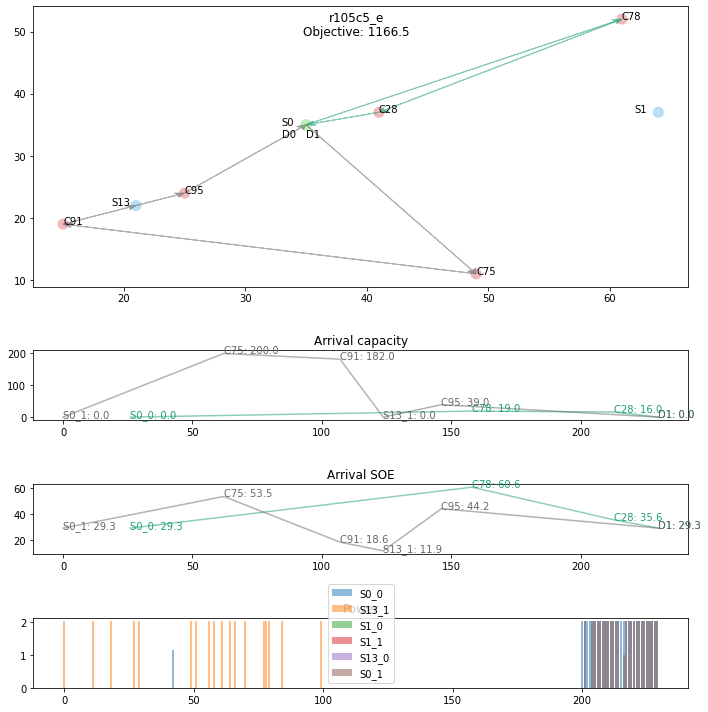

In [1052]:
fig, axs = plt.subplots(4, 1, figsize=(10,10), gridspec_kw={'height_ratios': [4, 1, 1, 1]})

title = ''
title += '{}\n'.format(m.instance_name)
title += 'Objective: {}'.format(round(m.instance.obj.expr(), 2))
fig.suptitle(title)

a = 0.5

for i, n in enumerate('SDM'):
    # Plot the nodes
    axs[0].scatter(m.data[n]['d_x'], m.data[n]['d_y'], c=[node_colors_rgba_tuple[n]]*len(m.data[n]), s=100)

    # Annotate the nodes
    for j, txt in enumerate(m.data[n].index):
        scale = 2
        if n == 'D':
            offset = [-scale, -scale]
        elif n == 'S':
            offset = [-scale, 0]
        else:
            offset = [0, 0]
        if txt == 'D1':
            offset = [0, -scale]
            
        axs[0].annotate(txt, (m.data[n]['d_x'][j]+offset[0], m.data[n]['d_y'][j]+offset[1]))
        
# Get colors for each vehicle
c = plt.get_cmap('Dark2')
colors = [c(tc) for tc in np.linspace(0, 1, len(traces))]
    
# Plot the vehicle routes        
for ti, t in enumerate(traces):
    for ki, k in enumerate(t[:-1]):
        arrow_x = m.data['V_'].loc[t[ki], 'd_x']
        arrow_y = m.data['V_'].loc[t[ki], 'd_y']
        arrow_dx = m.data['V_'].loc[t[ki+1], 'd_x'] - arrow_x
        arrow_dy = m.data['V_'].loc[t[ki+1], 'd_y'] - arrow_y
        
        axs[0].arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, alpha=a,
                     length_includes_head=True, head_width=.75, head_length=.75, overhang=.25, color=colors[ti])
        
    # Plot the vehicle states
    r = routes.loc[list(zip(t[:-1], t[1:]))]
    
    # Plot arrival capacity
    axs[1].plot(r['xw'], r['xq'], color=colors[ti], alpha=a)
    axs[1].title.set_text('Arrival capacity')    
    for row in r.iterrows():
        axs[1].annotate('{}: {:.1f}'.format(row[0][1], row[1]['xq']), xy=(row[1]['xw'], row[1]['xq']), color=colors[ti])
    
    # Plot arrival SOE
    axs[2].plot(r['xw'], r['xa'], color=colors[ti], alpha=a)
    axs[2].title.set_text('Arrival SOE')
    for row in r.iterrows():
        axs[2].annotate('{}: {:.1f}'.format(row[0][1], row[1]['xa']), xy=(row[1]['xw'], row[1]['xa']), color=colors[ti])
    
    
# Plot power
stations = xp['node'].unique()
for s in stations:
    axs[3].bar(xp[xp['node']==s]['t'], xp[xp['node']==s]['xp'], label=s, alpha=a)

axs[3].legend()
axs[3].title.set_text('Power')    

fig.tight_layout()

In [1001]:
xp.groupby('node').sum()

,t,state,xp
node,,,
S0_0,3766,34.0,69.387755
S0_1,4613,45.0,91.836735
S13_1,730,10.0,20.408163


In [936]:
m.instance.obj.expr()

156.08206946417084